# Свёрточные нейронные сети 

Гопиенко Александр

In [1]:
import torch
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset

### Создание датасетов

In [2]:
def load_images(folder, label):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            image = Image.open(img_path).convert("RGB")
            images.append((image, label))
        except Exception as e:
            print(f"Ошибка с файлом {img_path}: {e}")
    return images

data_dir = "./archive"
train_food_dir = os.path.join(data_dir, "training/food")
train_non_food_dir = os.path.join(data_dir, "training/non_food")
val_food_dir = os.path.join(data_dir, "validation/food")
val_non_food_dir = os.path.join(data_dir, "validation/non_food")
test_food_dir = os.path.join(data_dir, "evaluation/food")
test_non_food_dir = os.path.join(data_dir, "evaluation/non_food")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
class FoodDataset(Dataset):
    def __init__(self, food_dir, non_food_dir, transform=None):
        self.data = []
        self.transform = transform

        self.data.extend(load_images(food_dir, 1))
        self.data.extend(load_images(non_food_dir, 0))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)
    
train_dataset = FoodDataset(train_food_dir, train_non_food_dir, transform)
val_dataset = FoodDataset(val_food_dir, val_non_food_dir, transform)
test_dataset = FoodDataset(test_food_dir, test_non_food_dir, transform)

# Уменьшение размеров выборок
train_size = 300
val_size = 100
test_size = 100

# Выбор случайных подмножеств
train_indices = np.random.choice(len(train_dataset), train_size, replace=False)
val_indices = np.random.choice(len(val_dataset), val_size, replace=False)
test_indices = np.random.choice(len(test_dataset), test_size, replace=False)

# Создание подмножеств
train_subset = Subset(train_dataset, train_indices.tolist())
val_subset = Subset(val_dataset, val_indices.tolist())
test_subset = Subset(test_dataset, test_indices.tolist())

# Создание DataLoader'ов
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=32, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_subset, batch_size=32, num_workers=4, pin_memory=True)

print(f"Количество изображений в train: {len(train_loader)}")
print(f"Количество изображений в validation: {len(val_loader)}")
print(f"Количество изображений в test: {len(test_loader)}")

Количество изображений в train: 3000
Количество изображений в validation: 1000
Количество изображений в test: 1000


### Примеры изображения

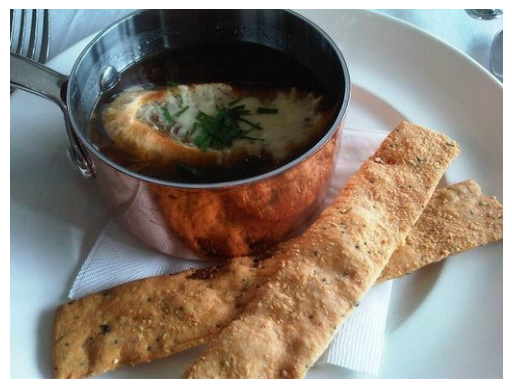

In [4]:
filename = os.listdir(train_food_dir)[0]
image_path = os.path.join(train_food_dir, filename)

if os.path.exists(image_path):
    image = Image.open(image_path).convert("RGB")  
    plt.imshow(image)
    plt.axis("off")  
    plt.show()
else:
    print(f"Файл {image_path} не найден!")

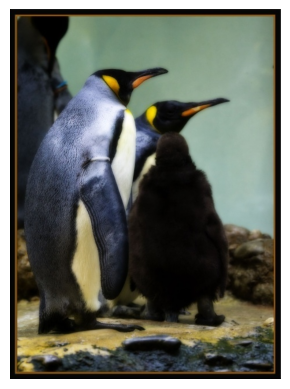

In [5]:
filename = os.listdir(train_non_food_dir)[0]
image_path = os.path.join(train_non_food_dir, filename)

if os.path.exists(image_path):
    image = Image.open(image_path).convert("RGB")  
    plt.imshow(image)
    plt.axis("off")  
    plt.show()
else:
    print(f"Файл {image_path} не найден!")

### Создание архитектур нейронных сетей

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class CNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AdaptiveAvgPool2d((4, 4))  # Подстраивает размер перед полносвязным слоем
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 4 * 4, 128),  # Теперь входной размер 128 * 4 * 4 вместо фиксированного 64 * 56 * 56
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Разворачивает тензор перед полносвязным слоем
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
patience = 3
best_val_loss = np.inf
epochs_no_improve = 0

best_model_wts = model.state_dict()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_wts = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

model.load_state_dict(best_model_wts)

model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")
